# Explorations of Cumulant Decompositions

We're going to consider a simple 1D system with a particle connected to two springs that are anchored to $x=-1$ and $x=1$. The system has the Hamiltonian:
\begin{align}
H(x, \lambda) =& \frac{1}{2} k_0 \left[ (x - 1)^2 + (x + 1)^2 \right] +
    \frac{f(\lambda)}{2} (k_1 - k_0) (x - 1)^2 +
    \frac{g(\lambda)}{2} (k_2 - k_0) (x + 1)^2 \\
    =& H_0(x) + \Delta H_1(x, \lambda) + \Delta H_2(x, \lambda).
\end{align}

We will consider the decomposition into the following free energy components:
* $A$: the total free energy
* $A_1$: the change in the total free energy when $\Delta H_1=0$
* $A_2$: the change in the total free energy when $\Delta H_2=0$
* $C_{12}$: the extra change in total free energy when $\Delta H_1 = \Delta H_2 = 0$.

For this simple system, $A_1$ + $A_2$ + $C_{12}$ = $A$.

We will consider the case where $k_1 = k_2$, which implies that $A_1 = A_2$.

**Note:** although the particle configuration will be a Gaussian distribution, the Hamiltonian components *do not* have a Gaussian distribution, so the higher-order cumulants will be non-zero.

# Code

In [1]:
from collections import namedtuple
import random
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as pp
%matplotlib inline

In [2]:
# named tuple to hold energy components
Energy = namedtuple('Energy', 'total H0 H1 H2 unscaled_H1 unscaled_H2 f g df dg dH dH1 dH2')

In [3]:
def compute_energy(x, k0, k1, k2, f, g, lambda_):
    """Compute the energy and its components for a configuration"""
    H0 = 0.5 * k0 * (x - 1)**2 + 0.5 * k0 * (x + 1)**2
    H1 = 0.5 * (k1 - k0) * (x + 1)**2
    H2 = 0.5 * (k2 - k0) * (x - 1)**2
    scale1, d1 = f(lambda_)
    scale2, d2 = g(lambda_)
    scaled_H1 = scale1 * H1
    scaled_H2 = scale2 * H2
    total = H0 + scaled_H1 + scaled_H2
    return Energy(total, H0, scaled_H1, scaled_H2, H1, H2, scale1, scale2, d1, d2, d1*H1 + d2*H2, d1*H1, d2*H2)

## Scaling Functions

We will consider three variations of the scaling functions $f_i(\lambda)$ and $g_i(\lambda)$ for $i \in [1,2,3]$.

In [4]:
def f1(lambda_):
    """Simultaneous scaling"""
    assert lambda_ >= 0 and lambda_ <= 1
    return lambda_, 1.0

g1 = f1

def f2(lambda_):
    """f() first, then g()"""
    assert lambda_ >= 0 and lambda_ <= 1
    if lambda_ <= 0.5:
        return 2.0 * lambda_, 2.0
    else:
        return 1.0, 0.0

def f3(lambda_):
    """g() first, then f()"""
    assert lambda_ >= 0 and lambda_ <= 1
    if lambda_ >= 0.5:
        return 2.0 * (lambda_ - 0.5), 2.0
    else:
        return 0.0, 0.0
    
g2 = f3
g3 = f2


Our three functions look like this:

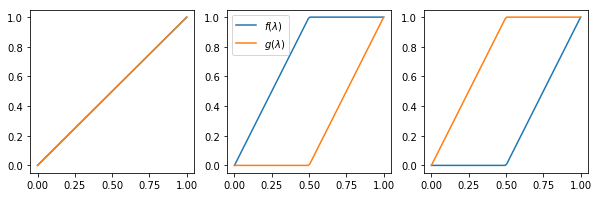

In [5]:
lambdas = np.linspace(0, 1, 100)
pp.figure(figsize=(10, 3))
pp.subplot(1, 3, 1)
pp.plot(lambdas, [f1(lam)[0] for lam in lambdas])
pp.plot(lambdas, [g1(lam)[0] for lam in lambdas])
pp.subplot(1, 3, 2)
pp.plot(lambdas, [f2(lam)[0] for lam in lambdas], label=r'$f(\lambda)$')
pp.plot(lambdas, [g2(lam)[0] for lam in lambdas], label=r'$g(\lambda)$')
pp.legend()
pp.subplot(1, 3, 3)
pp.plot(lambdas, [f3(lam)[0] for lam in lambdas])
pp.plot(lambdas, [g3(lam)[0] for lam in lambdas]);

## Monte Carlo

In [6]:
def update(x, k0, k1, k2, f, g, lambda_, steps):
    for step in range(steps):
        x_trial = x + random.gauss(0.0, 0.1)
        e_init = compute_energy(x, k0, k1, k2, f, g, lambda_)
        e_trial = compute_energy(x_trial, k0, k1, k2, f, g, lambda_)
        delta = e_trial.total - e_init.total
        if delta < 0:
            accept = True
        else:
            if random.random() < math.exp(-delta):
                accept = True
            else:
                accept = False
        
        if accept:
            x = x_trial
    return x, compute_energy(x, k0, k1, k2, f, g, lambda_)

In [7]:
def compute_curve(n_points, steps, walk_steps, k0, k1, k2, f, g):
    lambdas = np.linspace(0, 1, n_points)
    position_results = {}
    energy_results = {}
    for lambda_ in lambdas:
        positions = []
        energies = []
        x = 0.0
        for step in range(steps):
            x, energy = update(x, k0, k1, k2, f, g, lambda_, walk_steps)
            positions.append(x)
            energies.append(energy)
        positions = np.array(positions)
        energies = pd.DataFrame(energies)
        position_results[lambda_] = positions
        energy_results[lambda_] = energies
    
    return position_results, energy_results
        

In [8]:
def plot_derivs(lambdas,
                dH_1, dH1_1, dH2_1,
                dH_2, dH1_2, dH2_2,
                dH_3, dH1_3, dH2_3):
    pp.figure(figsize=(10, 3))
    pp.subplot(1, 3, 1)
    pp.plot(lambdas, dH_1, linewidth=4)
    pp.plot(lambdas, dH1_1)
    pp.plot(lambdas, dH2_1)
    pp.ylim(0, 30)
    pp.subplot(1, 3, 2)
    pp.plot(lambdas, dH_2, linewidth=4)
    pp.plot(lambdas, dH1_2)
    pp.plot(lambdas, dH2_2)
    pp.ylim(0, 30);
    pp.subplot(1, 3, 3)
    pp.plot(lambdas, dH_3, linewidth=4)
    pp.plot(lambdas, dH1_3)
    pp.plot(lambdas, dH2_3)
    pp.ylim(0, 30);

In [9]:
def plot_components(lambdas,
                    dH_1, dH1_1, dH2_1,
                    dH_2, dH1_2, dH2_2,
                    dH_3, dH1_3, dH2_3):
    A_1, A1_1, A2_1, C12_1 = compute_integrals(lambdas, dH_1, dH1_1, dH2_1)
    A_2, A1_2, A2_2, C12_2 = compute_integrals(lambdas, dH_2, dH1_2, dH2_2)
    A_3, A1_3, A2_3, C12_3 = compute_integrals(lambdas, dH_3, dH1_3, dH2_3)
    
    pp.bar([0, 1, 2, 3], [A_1, A1_1, A2_1, C12_1])
    pp.bar([5, 6, 7, 8], [A_2, A1_2, A2_2, C12_2])
    pp.bar([10, 11, 12, 13], [A_3, A1_3, A2_3, C12_3])
    
    pp.axhline(10.15, color='grey', linestyle='--')
    pp.axhline(8.48, color='grey', linestyle='--')
    pp.axhline(-6.81, color='grey', linestyle='--')
    
    pp.xticks(
        [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13],
        ['$A$', '$A_1$', '$A_2$', '$C_{12}$',
         '$A$', '$A_1$', '$A_2$', '$C_{12}$',
         '$A$', '$A_1$', '$A_2$', '$C_{12}$']
    )

## Compute Naïve Averages

The code below uses the path-dependent naïve scheme.

The components are:
\begin{equation}
A_1' = \langle H_1' \rangle
\end{equation}

In [10]:
def extract_averages(energies):
    lambdas = list(energies.keys())
    dH = [energies[lam]['dH'].mean() for lam in lambdas]
    dH1 = [energies[lam]['dH1'].mean() for lam in lambdas]
    dH2 = [energies[lam]['dH2'].mean() for lam in lambdas]
    return lambdas, dH, dH1, dH2

In [11]:
def compute_integrals(lambdas, dH, dH1, dH2):
    A = np.trapz(dH, lambdas)
    A1 = np.trapz(dH1, lambdas)
    A2 = np.trapz(dH2, lambdas)
    C12 = A - A1 - A2
    return A, A1, A2, C12

## Exponential Reweighting

The code below will use the full exponential weighting scheme. In principle, this is exact, but may have a high variance when estimated due to poor overlap between ensembles and strong dependence between Hamiltonian components.

The components are corrected by:
\begin{equation}
A_1' = \langle H_1' \rangle  + \langle H_2' \rangle - \frac{\langle H_2' e^{H_1} \rangle}{\langle e^{H_1} \rangle}
\end{equation}

In [12]:
def compute_exp_reweight(deriv, energy):
    max_energy = max(energy)
    weights = np.exp(energy - max_energy)
    return np.mean(weights * deriv) / np.mean(weights)

In [13]:
def extract_reweighted_averages(energies):
    lambdas = list(energies.keys())
    dH = np.array([energies[lam]['dH'].mean() for lam in lambdas])
    dH1 = np.array([energies[lam]['dH1'].mean() for lam in lambdas])
    dH2 = np.array([energies[lam]['dH2'].mean() for lam in lambdas])
    dH1w = np.array([compute_exp_reweight(energies[lam]['dH1'], energies[lam]['H2']) for lam in lambdas])
    dH2w = np.array([compute_exp_reweight(energies[lam]['dH2'], energies[lam]['H1']) for lam in lambdas])
    return lambdas, dH, dH1 + dH2 - dH2w, dH1 + dH2 - dH1w

# 1st Order Cumulant

The code below uses the first order cumulant expansion. This is an approximation, because the Taylor series is truncated at first order, but it may be less noisy than the exponential average.

The components are corrected by:
\begin{equation}
A_1' = \langle H_1' \rangle  - \left( \langle H_2' H_1 \rangle - \langle H_2' \rangle \langle H_1 \rangle \right).
\end{equation}

In [14]:
def compute_cum1(deriv, energy):
    return np.mean(deriv * energy) - np.mean(deriv) * np.mean(energy)

In [15]:
def extract_cum1_averages(energies):
    lambdas = list(energies.keys())
    dH = np.array([energies[lam]['dH'].mean() for lam in lambdas])
    dH1 = np.array([energies[lam]['dH1'].mean() for lam in lambdas])
    dH2 = np.array([energies[lam]['dH2'].mean() for lam in lambdas])
    dH1c = np.array([compute_cum1(energies[lam]['dH1'], energies[lam]['H2']) for lam in lambdas])
    dH2c = np.array([compute_cum1(energies[lam]['dH2'], energies[lam]['H1']) for lam in lambdas])
    return lambdas, dH, dH1 - dH2c, dH2 - dH1c

# 2nd Order Cumulant

The code below uses the second order cumulant expansion. This is an approximation, because the Taylor series is truncated at second order, but it may be less noisy than the exponential average. It should be more accurate than the first order expansion, but may be more noisy.

The components are corrected by:

\begin{equation}
A_1' = \langle H_1' \rangle  - \left( \langle H_2' H_1 \rangle - \langle H_2' \rangle \langle H_1 \rangle \right)
    - \frac{1}{2}
    \left(
        \langle H_2' H_1^2 \rangle
        - 2 \langle H_2' H_1 \rangle \langle H_1\rangle
        - \langle H_2'\rangle \langle H_1^2 \rangle
        + 2 \langle H_2' \rangle \langle H_1 \rangle^2
    \right)
\end{equation}


In [16]:
def compute_cum2(deriv, energy):
    return compute_cum1(deriv, energy) + 0.5 * (
        np.mean(deriv * energy**2) -
        2 * np.mean(deriv * energy) * np.mean(energy) -
        np.mean(deriv) * np.mean(energy**2) +
        2 * np.mean(deriv) * np.mean(energy)**2
    )

In [17]:
def extract_cum2_averages(energies):
    lambdas = list(energies.keys())
    dH = np.array([energies[lam]['dH'].mean() for lam in lambdas])
    dH1 = np.array([energies[lam]['dH1'].mean() for lam in lambdas])
    dH2 = np.array([energies[lam]['dH2'].mean() for lam in lambdas])
    dH1c = np.array([compute_cum2(energies[lam]['dH1'], energies[lam]['H2']) for lam in lambdas])
    dH2c = np.array([compute_cum2(energies[lam]['dH2'], energies[lam]['H1']) for lam in lambdas])
    return lambdas, dH, dH1 - dH2c, dH2 - dH1c

# Results

## Long Runs

**WARNING:** This takes a long time to run.

In [19]:
STEPS = 25_000

In [19]:
positions_long_1, energies_long_1 = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f1, g1)
positions_long_2, energies_long_2 = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f2, g2)
positions_long_3, energies_long_3 = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f3, g3)

## Naïve Decomposition

In [20]:
lambdas, dH_long_1_naive, dH1_long_1_naive, dH2_long_1_naive = extract_averages(energies_long_1)
_,       dH_long_2_naive, dH1_long_2_naive, dH2_long_2_naive = extract_averages(energies_long_2)
_,       dH_long_3_naive, dH1_long_3_naive, dH2_long_3_naive = extract_averages(energies_long_3)

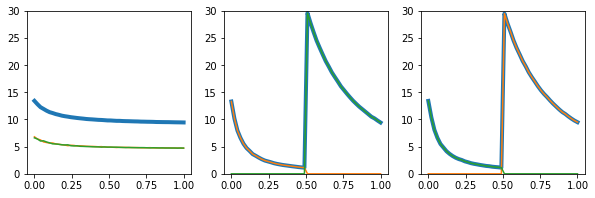

In [21]:
plot_derivs(lambdas,
            dH_long_1_naive, dH1_long_1_naive, dH2_long_1_naive,
            dH_long_2_naive, dH1_long_2_naive, dH2_long_2_naive,
            dH_long_3_naive, dH1_long_3_naive, dH2_long_3_naive)

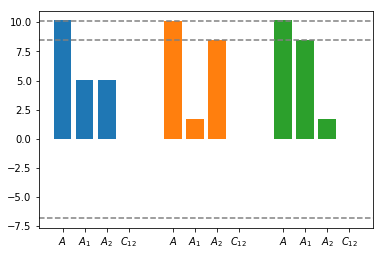

In [22]:
plot_components(lambdas,
                dH_long_1_naive, dH1_long_1_naive, dH2_long_1_naive,
                dH_long_2_naive, dH1_long_2_naive, dH2_long_2_naive,
                dH_long_3_naive, dH1_long_3_naive, dH2_long_3_naive)

* $A$ is the same in all cases, as expected
* For identical scaling $A_1 = A_2 = \frac{1}{2} A$
* For the other cases, $A_1 \neq A_2$
* The coupling is zero in all cases
* One of the components for cases 2 and 3 gives the free energy if either $H_1=0$ or $H_2=0$

## Full Exponential Re-weighting Decomposition

In [23]:
lambdas, dH_long_1_exp, dH1_long_1_exp, dH2_long_1_exp = extract_reweighted_averages(energies_long_1)
_,       dH_long_2_exp, dH1_long_2_exp, dH2_long_2_exp = extract_reweighted_averages(energies_long_2)
_,       dH_long_3_exp, dH1_long_3_exp, dH2_long_3_exp = extract_reweighted_averages(energies_long_3)

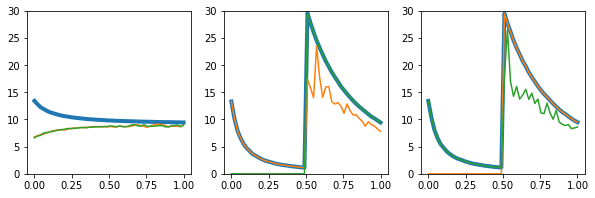

In [24]:
plot_derivs(lambdas,
            dH_long_1_exp, dH1_long_1_exp, dH2_long_1_exp,
            dH_long_2_exp, dH1_long_2_exp, dH2_long_2_exp,
            dH_long_3_exp, dH1_long_3_exp, dH2_long_3_exp)

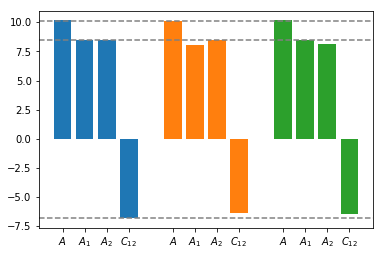

In [25]:
plot_components(lambdas,
                dH_long_1_exp, dH1_long_1_exp, dH2_long_1_exp,
                dH_long_2_exp, dH1_long_2_exp, dH2_long_2_exp,
                dH_long_3_exp, dH1_long_3_exp, dH2_long_3_exp)

* All three cases give very similar scaling
* The values are very close to what is expected for the $H_1=0$ and $H_2=0$ cases
* $A_1 = A_2$, as expected
* The coupling term is large and has the correct value
* The corrected $A_1'$ and $A_2'$ traces are noisy

## First Order Cumulant Decomposition

In [26]:
lambdas, dH_long_1_cum1, dH1_long_1_cum1, dH2_long_1_cum1 = extract_cum1_averages(energies_long_1)
_,       dH_long_2_cum1, dH1_long_2_cum1, dH2_long_2_cum1 = extract_cum1_averages(energies_long_2)
_,       dH_long_3_cum1, dH1_long_3_cum1, dH2_long_3_cum1 = extract_cum1_averages(energies_long_3)

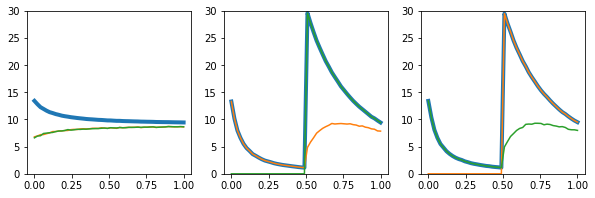

In [27]:
plot_derivs(lambdas,
            dH_long_1_cum1, dH1_long_1_cum1, dH2_long_1_cum1,
            dH_long_2_cum1, dH1_long_2_cum1, dH2_long_2_cum1,
            dH_long_3_cum1, dH1_long_3_cum1, dH2_long_3_cum1)

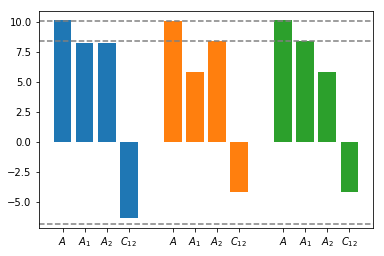

In [28]:
plot_components(lambdas,
                dH_long_1_cum1, dH1_long_1_cum1, dH2_long_1_cum1,
                dH_long_2_cum1, dH1_long_2_cum1, dH2_long_2_cum1,
                dH_long_3_cum1, dH1_long_3_cum1, dH2_long_3_cum1)

* First order gets closer to correct values
  * Better than naïve, but still some path dependence
* $A_1 \approx A_2$, but correction isn't complete
* The coupling term is large and trends towards the correct value
* The corrected $A_1'$ and $A_2'$ traces are relatively noise-free

## Second Order Cumulant Decomposition

In [29]:
lambdas, dH_long_1_cum2, dH1_long_1_cum2, dH2_long_1_cum2 = extract_cum2_averages(energies_long_1)
_,       dH_long_2_cum2, dH1_long_2_cum2, dH2_long_2_cum2 = extract_cum2_averages(energies_long_2)
_,       dH_long_3_cum2, dH1_long_3_cum2, dH2_long_3_cum2 = extract_cum2_averages(energies_long_3)

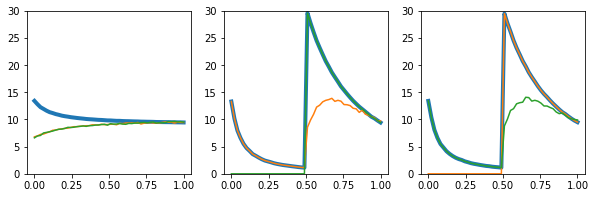

In [30]:
plot_derivs(lambdas,
            dH_long_1_cum2, dH1_long_1_cum2, dH2_long_1_cum2,
            dH_long_2_cum2, dH1_long_2_cum2, dH2_long_2_cum2,
            dH_long_3_cum2, dH1_long_3_cum2, dH2_long_3_cum2)

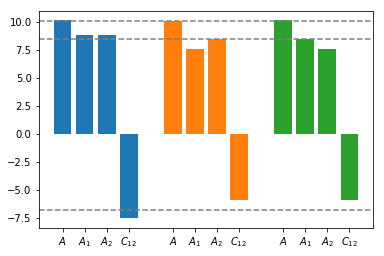

In [31]:
plot_components(lambdas,
                dH_long_1_cum2, dH1_long_1_cum2, dH2_long_1_cum2,
                dH_long_2_cum2, dH1_long_2_cum2, dH2_long_2_cum2,
                dH_long_3_cum2, dH1_long_3_cum2, dH2_long_3_cum2)

* Second order gets very close to correct values
  * Much better than naïve
  * Almost as good as exponential reweighting
* $A_1 = A_2$, as expected
* The coupling term is large and has the correct value
* The corrected $A_1'$ and $A_2'$ traces are relatively noise-free

## Short Runs

In [75]:
STEPS = 25

In [76]:
positions_short_1, energies_short_1 = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f1, g1)
positions_short_2, energies_short_2 = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f2, g2)
positions_short_3, energies_short_3 = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f3, g3)

## Naïve Decomposition

In [77]:
lambdas, dH_short_1_naive, dH1_short_1_naive, dH2_short_1_naive = extract_averages(energies_short_1)
_,       dH_short_2_naive, dH1_short_2_naive, dH2_short_2_naive = extract_averages(energies_short_2)
_,       dH_short_3_naive, dH1_short_3_naive, dH2_short_3_naive = extract_averages(energies_short_3)

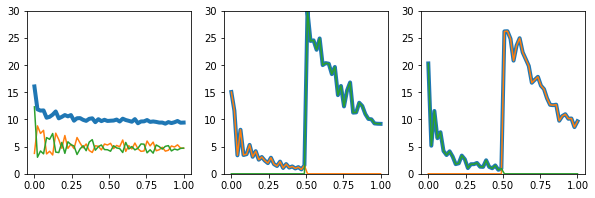

In [78]:
plot_derivs(lambdas,
            dH_short_1_naive, dH1_short_1_naive, dH2_short_1_naive,
            dH_short_2_naive, dH1_short_2_naive, dH2_short_2_naive,
            dH_short_3_naive, dH1_short_3_naive, dH2_short_3_naive)

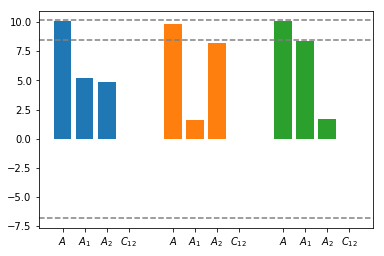

In [79]:
plot_components(lambdas,
                dH_short_1_naive, dH1_short_1_naive, dH2_short_1_naive,
                dH_short_2_naive, dH1_short_2_naive, dH2_short_2_naive,
                dH_short_3_naive, dH1_short_3_naive, dH2_short_3_naive)

## Full Exponential Re-weighting Decomposition

In [80]:
lambdas, dH_short_1_exp, dH1_short_1_exp, dH2_short_1_exp = extract_reweighted_averages(energies_short_1)
_,       dH_short_2_exp, dH1_short_2_exp, dH2_short_2_exp = extract_reweighted_averages(energies_short_2)
_,       dH_short_3_exp, dH1_short_3_exp, dH2_short_3_exp = extract_reweighted_averages(energies_short_3)

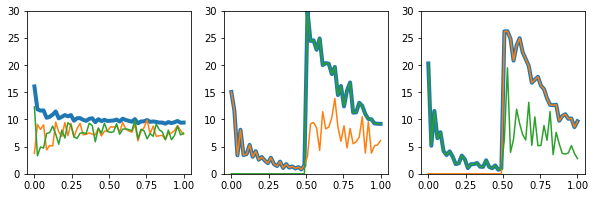

In [81]:
plot_derivs(lambdas,
            dH_short_1_exp, dH1_short_1_exp, dH2_short_1_exp,
            dH_short_2_exp, dH1_short_2_exp, dH2_short_2_exp,
            dH_short_3_exp, dH1_short_3_exp, dH2_short_3_exp)

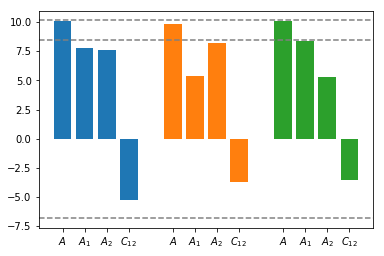

In [82]:
plot_components(lambdas,
                dH_short_1_exp, dH1_short_1_exp, dH2_short_1_exp,
                dH_short_2_exp, dH1_short_2_exp, dH2_short_2_exp,
                dH_short_3_exp, dH1_short_3_exp, dH2_short_3_exp)

## First Order Cumulant Decomposition

In [83]:
lambdas, dH_short_1_cum1, dH1_short_1_cum1, dH2_short_1_cum1 = extract_cum1_averages(energies_short_1)
_,       dH_short_2_cum1, dH1_short_2_cum1, dH2_short_2_cum1 = extract_cum1_averages(energies_short_2)
_,       dH_short_3_cum1, dH1_short_3_cum1, dH2_short_3_cum1 = extract_cum1_averages(energies_short_3)

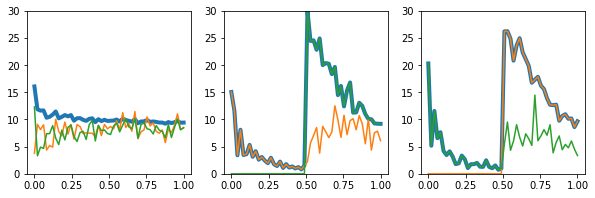

In [84]:
plot_derivs(lambdas,
            dH_short_1_cum1, dH1_short_1_cum1, dH2_short_1_cum1,
            dH_short_2_cum1, dH1_short_2_cum1, dH2_short_2_cum1,
            dH_short_3_cum1, dH1_short_3_cum1, dH2_short_3_cum1)

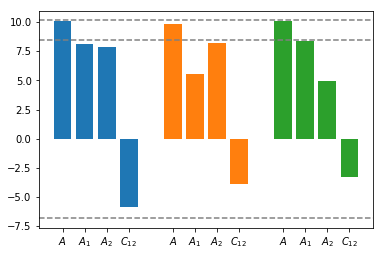

In [85]:
plot_components(lambdas,
                dH_short_1_cum1, dH1_short_1_cum1, dH2_short_1_cum1,
                dH_short_2_cum1, dH1_short_2_cum1, dH2_short_2_cum1,
                dH_short_3_cum1, dH1_short_3_cum1, dH2_short_3_cum1)

## Second Order Cumulant Decomposition

In [86]:
lambdas, dH_short_1_cum2, dH1_short_1_cum2, dH2_short_1_cum2 = extract_cum2_averages(energies_short_1)
_,       dH_short_2_cum2, dH1_short_2_cum2, dH2_short_2_cum2 = extract_cum2_averages(energies_short_2)
_,       dH_short_3_cum2, dH1_short_3_cum2, dH2_short_3_cum2 = extract_cum2_averages(energies_short_3)

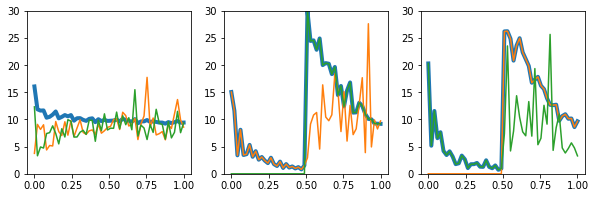

In [87]:
plot_derivs(lambdas,
            dH_short_1_cum2, dH1_short_1_cum2, dH2_short_1_cum2,
            dH_short_2_cum2, dH1_short_2_cum2, dH2_short_2_cum2,
            dH_short_3_cum2, dH1_short_3_cum2, dH2_short_3_cum2)

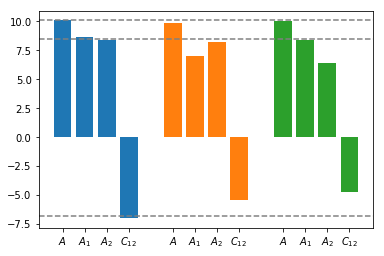

In [88]:
plot_components(lambdas,
                dH_short_1_cum2, dH1_short_1_cum2, dH2_short_1_cum2,
                dH_short_2_cum2, dH1_short_2_cum2, dH2_short_2_cum2,
                dH_short_3_cum2, dH1_short_3_cum2, dH2_short_3_cum2)

## Variability

We're only going to consider Path 2.

In [20]:
STEPS = 10
TRIALS = 50

In [21]:
A_naive = []
A1_naive = []
A2_naive = []
C12_naive = []
A_exp = []
A1_exp = []
A2_exp = []
C12_exp = []
A_cum1 = []
A1_cum1 = []
A2_cum1 = []
C12_cum1 = []
A_cum2 = []
A1_cum2 = []
A2_cum2 = []
C12_cum2 = []

for trial in range(TRIALS):
    positions_short_2, energies_short_2 = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f2, g2)

    lambdas, dH_short_2_naive, dH1_short_2_naive, dH2_short_2_naive = extract_averages(energies_short_2)
    x, y, z, w = compute_integrals(lambdas, dH_short_2_naive, dH1_short_2_naive, dH2_short_2_naive)
    A_naive.append(x)
    A1_naive.append(y)
    A2_naive.append(z)
    C12_naive.append(w)
    
    _,       dH_short_2_exp, dH1_short_2_exp, dH2_short_2_exp = extract_reweighted_averages(energies_short_2)
    x, y, z, w = compute_integrals(lambdas, dH_short_2_exp, dH1_short_2_exp, dH2_short_2_exp)
    A_exp.append(x)
    A1_exp.append(y)
    A2_exp.append(z)
    C12_exp.append(w)
    
    _,       dH_short_2_cum1, dH1_short_2_cum1, dH2_short_2_cum1 = extract_cum1_averages(energies_short_2)
    x, y, z, w = compute_integrals(lambdas, dH_short_2_cum1, dH1_short_2_cum1, dH2_short_2_cum1)
    A_cum1.append(x)
    A1_cum1.append(y)
    A2_cum1.append(z)
    C12_cum1.append(w)
    
    _,       dH_short_2_cum2, dH1_short_2_cum2, dH2_short_2_cum2 = extract_cum2_averages(energies_short_2)
    x, y, z, w = compute_integrals(lambdas, dH_short_2_cum2, dH1_short_2_cum2, dH2_short_2_cum2)
    A_cum2.append(x)
    A1_cum2.append(y)
    A2_cum2.append(z)
    C12_cum2.append(w)

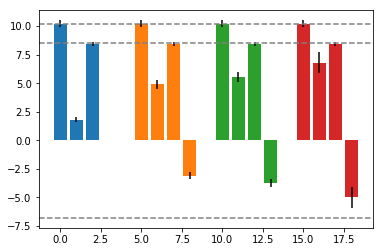

In [22]:
pp.bar([0, 1, 2, 3],
       [np.mean(A_naive), np.mean(A1_naive), np.mean(A2_naive), np.mean(C12_naive)],
       yerr=[np.std(A_naive), np.std(A1_naive), np.std(A2_naive), np.std(C12_naive)]
      )
pp.bar([5, 6, 7, 8],
       [np.mean(A_exp), np.mean(A1_exp), np.mean(A2_exp), np.mean(C12_exp)],
       yerr=[np.std(A_exp), np.std(A1_exp), np.std(A2_exp), np.std(C12_exp)]
      )
pp.bar([10, 11, 12, 13],
       [np.mean(A_cum1), np.mean(A1_cum1), np.mean(A2_cum1), np.mean(C12_cum1)],
       yerr=[np.std(A_cum1), np.std(A1_cum1), np.std(A2_cum1), np.std(C12_cum1)]
      )
pp.bar([15, 16, 17, 18],
       [np.mean(A_cum2), np.mean(A1_cum2), np.mean(A2_cum2), np.mean(C12_cum2)],
       yerr=[np.std(A_cum2), np.std(A1_cum2), np.std(A2_cum2), np.std(C12_cum2)]
      )
pp.axhline(10.15, color='grey', linestyle='--')
pp.axhline(8.48, color='grey', linestyle='--')
pp.axhline(-6.81, color='grey', linestyle='--');

In [23]:
STEPS = 250
TRIALS = 50

In [24]:
A_naive = []
A1_naive = []
A2_naive = []
C12_naive = []
A_exp = []
A1_exp = []
A2_exp = []
C12_exp = []
A_cum1 = []
A1_cum1 = []
A2_cum1 = []
C12_cum1 = []
A_cum2 = []
A1_cum2 = []
A2_cum2 = []
C12_cum2 = []

for trial in range(TRIALS):
    positions_short_2, energies_short_2 = compute_curve(50, STEPS, 50, 1.0, 10.0, 10.0, f2, g2)

    lambdas, dH_short_2_naive, dH1_short_2_naive, dH2_short_2_naive = extract_averages(energies_short_2)
    x, y, z, w = compute_integrals(lambdas, dH_short_2_naive, dH1_short_2_naive, dH2_short_2_naive)
    A_naive.append(x)
    A1_naive.append(y)
    A2_naive.append(z)
    C12_naive.append(w)
    
    _,       dH_short_2_exp, dH1_short_2_exp, dH2_short_2_exp = extract_reweighted_averages(energies_short_2)
    x, y, z, w = compute_integrals(lambdas, dH_short_2_exp, dH1_short_2_exp, dH2_short_2_exp)
    A_exp.append(x)
    A1_exp.append(y)
    A2_exp.append(z)
    C12_exp.append(w)
    
    _,       dH_short_2_cum1, dH1_short_2_cum1, dH2_short_2_cum1 = extract_cum1_averages(energies_short_2)
    x, y, z, w = compute_integrals(lambdas, dH_short_2_cum1, dH1_short_2_cum1, dH2_short_2_cum1)
    A_cum1.append(x)
    A1_cum1.append(y)
    A2_cum1.append(z)
    C12_cum1.append(w)
    
    _,       dH_short_2_cum2, dH1_short_2_cum2, dH2_short_2_cum2 = extract_cum2_averages(energies_short_2)
    x, y, z, w = compute_integrals(lambdas, dH_short_2_cum2, dH1_short_2_cum2, dH2_short_2_cum2)
    A_cum2.append(x)
    A1_cum2.append(y)
    A2_cum2.append(z)
    C12_cum2.append(w)

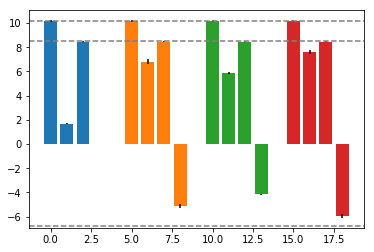

In [25]:
pp.bar([0, 1, 2, 3],
       [np.mean(A_naive), np.mean(A1_naive), np.mean(A2_naive), np.mean(C12_naive)],
       yerr=[np.std(A_naive), np.std(A1_naive), np.std(A2_naive), np.std(C12_naive)]
      )
pp.bar([5, 6, 7, 8],
       [np.mean(A_exp), np.mean(A1_exp), np.mean(A2_exp), np.mean(C12_exp)],
       yerr=[np.std(A_exp), np.std(A1_exp), np.std(A2_exp), np.std(C12_exp)]
      )
pp.bar([10, 11, 12, 13],
       [np.mean(A_cum1), np.mean(A1_cum1), np.mean(A2_cum1), np.mean(C12_cum1)],
       yerr=[np.std(A_cum1), np.std(A1_cum1), np.std(A2_cum1), np.std(C12_cum1)]
      )
pp.bar([15, 16, 17, 18],
       [np.mean(A_cum2), np.mean(A1_cum2), np.mean(A2_cum2), np.mean(C12_cum2)],
       yerr=[np.std(A_cum2), np.std(A1_cum2), np.std(A2_cum2), np.std(C12_cum2)]
      )
pp.axhline(10.15, color='grey', linestyle='--')
pp.axhline(8.48, color='grey', linestyle='--')
pp.axhline(-6.81, color='grey', linestyle='--');

Based on these results:
* It appears that the exponential for has reasonable variance
* The cum2 form has the largest variance
* The exponential form appears to be biased at small sample sizes
* The cum2 form seems to be less biased at small sample sizes

## Effect of sample size on corrections

Let's look at the results as a function of sample size.

We'll consider only Pathway 2, and plot $A_1$ as a function of the number of steps for all three corrections.

In [ ]:
steps = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16_384, 32_768]
means_exp = []
stds_exp = []
means_cum1 = []
stds_cum1 = []
means_cum2 = []
stds_cum2 = []

TRIALS = 8
for n_steps in steps:
    print(n_steps)
    values_exp = []
    values_cum1 = []
    values_cum2 = []
    for trial in range(TRIALS):
        positions_short_2, energies_short_2 = compute_curve(50, n_steps, 50, 1.0, 10.0, 10.0, f2, g2)
        lambdas, dH_short_2_exp, dH1_short_2_exp, dH2_short_2_exp = extract_reweighted_averages(energies_short_2)
        x, y, z, w = compute_integrals(lambdas, dH_short_2_exp, dH1_short_2_exp, dH2_short_2_exp)
        values_exp.append(y)
        
        _, dH_short_2_cum1, dH1_short_2_cum1, dH2_short_2_cum1 = extract_cum1_averages(energies_short_2)
        x, y, z, w = compute_integrals(lambdas, dH_short_2_cum1, dH1_short_2_cum1, dH2_short_2_cum1)
        values_cum1.append(y)

        _, dH_short_2_cum2, dH1_short_2_cum2, dH2_short_2_cum2 = extract_cum2_averages(energies_short_2)
        x, y, z, w = compute_integrals(lambdas, dH_short_2_cum2, dH1_short_2_cum2, dH2_short_2_cum2)
        values_cum2.append(y)

    means_exp.append(np.mean(values_exp))
    stds_exp.append(np.std(values_exp))
    means_cum1.append(np.mean(values_cum1))
    stds_cum1.append(np.std(values_cum1))
    means_cum2.append(np.mean(values_cum2))
    stds_cum2.append(np.std(values_cum2))

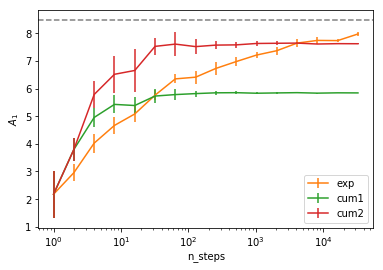

In [34]:
pp.errorbar(steps, means_exp, yerr=stds_exp, label='exp', color='C1')
pp.errorbar(steps, means_cum1, yerr=stds_cum1, label='cum1', color='C2')
pp.errorbar(steps, means_cum2, yerr=stds_cum2, label='cum2', color='C3')
pp.axhline(8.48, color='grey', linestyle='--')
pp.xscale('log')
pp.ylabel(r'$A_1$')
pp.xlabel('n_steps')
pp.legend()

* Cum1 is the least noisy, but systematically underestimates $A_1$.
* Cum2 is the most noisy. It also systematically underestimates $A_1$, but to a lesser degree than cum1.
* Exp appears to converge to the right value, but is biased at small sample sizes. Digging into some papers, this is a known effect of these sorts of non-linear averages.